# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

### Consolidar Base de Dados

In [ ]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10,
         'nov': 11, 'dez': 12}

In [ ]:
caminho_bases = pathlib.Path('dataset')
base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:-4]
    #ou ano = arquivo.name[-8:]
    #ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

display(base_airbnb)

FileNotFoundError: ignored

-Como temos muitas colunas, nosso modelo pode acabar ficando muito lento
-Além disso, uma análise rapida permite ver que várias colunas não são necessárias para nosso modelo de previsão, por isso vamos excluir algumas colunas da nossa base.
-Tipos de colunas que vamos excluir:
    1.IDs, Links e informações não relevantes para o modelo.
    2.Colunas repetidas ou extremamente parecidas com outras (que dão a mesma informação. Ex. data vs ano/mes)
    3.Colunas preenchidas com texto livre. Não rodaremos análise de palavras ou nada do tipo
    4.Colunas em que todos ou quase todos os valores são iguais
    5.
-Para isso, vamos criar um arquivo no excel com os 1000 primeiros registros e fazer uma análise qualitativa

In [ ]:
print(base_airbnb['experiences_offered'].value_counts())
print((base_airbnb['neighbourhood'] == base_airbnb['neighbourhood_cleansed']).value_counts())



none    902210
Name: experiences_offered, dtype: int64
True     754027
False    148183
dtype: int64


In [ ]:
print(base_airbnb['square_feet'].isnull().sum())

888162


In [ ]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros-registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

<h3> Depois da análise qualitativa das colunas, levando em cont os critérios explicados, ficamos com as seguintes colunas: </h3>

In [ ]:
colunas = ['house_rules','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_listings_count','latitude','longitude','is_location_exact','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','square_feet','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:, colunas]

display(base_airbnb)

,house_rules,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,latitude,longitude,is_location_exact,property_type,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,strictly no smoking in the apartment ! We want...,NaN,NaN,NaN,f,1.0,-22.946854,-43.182737,t,Apartment,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,Please leave the apartment in a clean fashion ...,within an hour,100%,NaN,t,2.0,-22.965919,-43.178962,t,Condominium,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,Please remove sand when you come from the beac...,within an hour,100%,NaN,f,1.0,-22.985698,-43.201935,t,Apartment,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,Smoking outside only. Family building so pleas...,within an hour,100%,NaN,f,3.0,-22.977117,-43.190454,t,Apartment,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,"So far, I haven't had any problems with guests...",within an hour,100%,NaN,t,1.0,-22.983024,-43.214270,t,Apartment,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,NaN,within an hour,93%,NaN,f,0.0,-23.003180,-43.342840,f,Apartment,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,NaN,NaN,f,0.0,-22.966640,-43.393450,t,Apartment,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,Tudo dentro do bom senso! Deixar o apartamento...,within a few hours,74%,NaN,f,32.0,-22.962080,-43.175520,t,Apartment,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,Permitido fumar somente na area externa,NaN,NaN,NaN,f,0.0,-23.003400,-43.341820,t,Apartment,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando
-Visualizando os dados percebemos que há uma grande disparidade de dados faltantes. As colunas com mais de 300.000 valores Nan foram excluídas da análise.
-Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados Nan.

In [ ]:
print(base_airbnb.isnull().sum())
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb.drop(coluna, axis=1, inplace=True)
        print(f'Coluna {coluna} excluida')

house_rules                    444397
host_response_time             401843
host_response_rate             401846
host_acceptance_rate           807468
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
is_location_exact                   0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
square_feet                    888162
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_score

In [ ]:
base_airbnb.drop('is_location_exact', axis=1, inplace=True)
base_airbnb.dropna(inplace=True) #excluindo os valores Nan
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64
(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [ ]:
print(type(base_airbnb))
print(base_airbnb.dtypes)
print('-' * 60)
print(base_airbnb.iloc[0])

<class 'pandas.core.frame.DataFrame'>
host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                          object
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                          

-Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo da varável da coluna.

In [ ]:
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '').str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '').str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32)
print(base_airbnb.iloc[0])
print(base_airbnb['price'].dtype)
print(base_airbnb['extra_people'].dtype)
print(base_airbnb.dtypes)

C:\Users\vnsou\AppData\Local\Temp/ipykernel_12920/1601259816.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '').str.replace(',', '')
C:\Users\vnsou\AppData\Local\Temp/ipykernel_12920/1601259816.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '').str.replace(',', '')


host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

### Análise Exploratória e Tratar Outliers


- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

<AxesSubplot:>

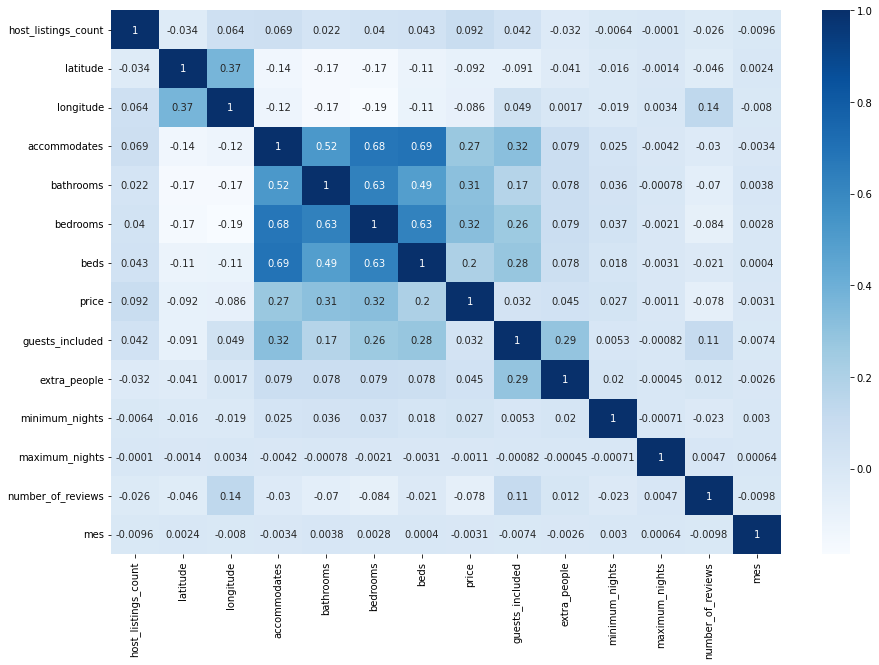

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(),annot=True,cmap='Blues')

### Definição de funções para a Análise de Outliers
-Vamos definir algumas funções para ajudar na análise de outliers nas colunas

In [ ]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    limite_inferior = q1 - 1.5 * amplitude
    limite_superior = q3 + 1.5 * amplitude
    return limite_inferior, limite_superior
def excluir_outliers(df, nome_coluna):
    qntde_linhas = df.shape[0]
    limite_superior, limite_inferior = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] > limite_superior) & (df[nome_coluna] < limite_inferior), :]
    linhas_removidas = qntde_linhas - df.shape[0]
    return df, linhas_removidas
'''def excluir_outliers(coluna):
    limite_inferior, limite_superior = limites(coluna)
    outliers = 0
    for preco in coluna:
        if preco > limite_superior or preco < limite_inferior :
            outliers += 1
    print(f'Foram detectados {outliers} outliers')'''

"def excluir_outliers(coluna):\n    limite_inferior, limite_superior = limites(coluna)\n    outliers = 0\n    for preco in coluna:\n        if preco > limite_superior or preco < limite_inferior :\n            outliers += 1\n    print(f'Foram detectados {outliers} outliers')"

In [ ]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
def histograma(coluna):
    # plt.figure(figsize=(60, 15))
    sns.displot(data=coluna, aspect=4, kde=True)
def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Price

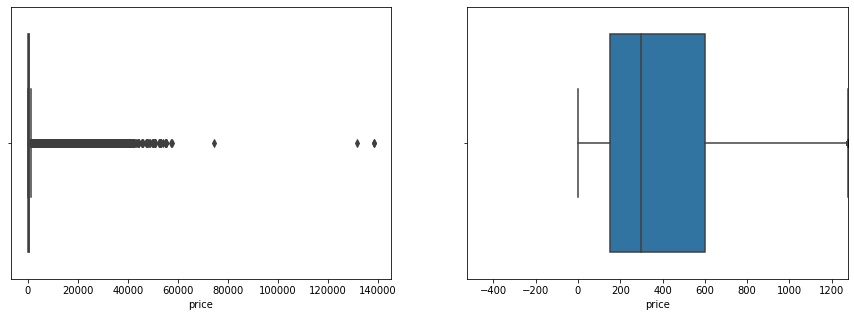

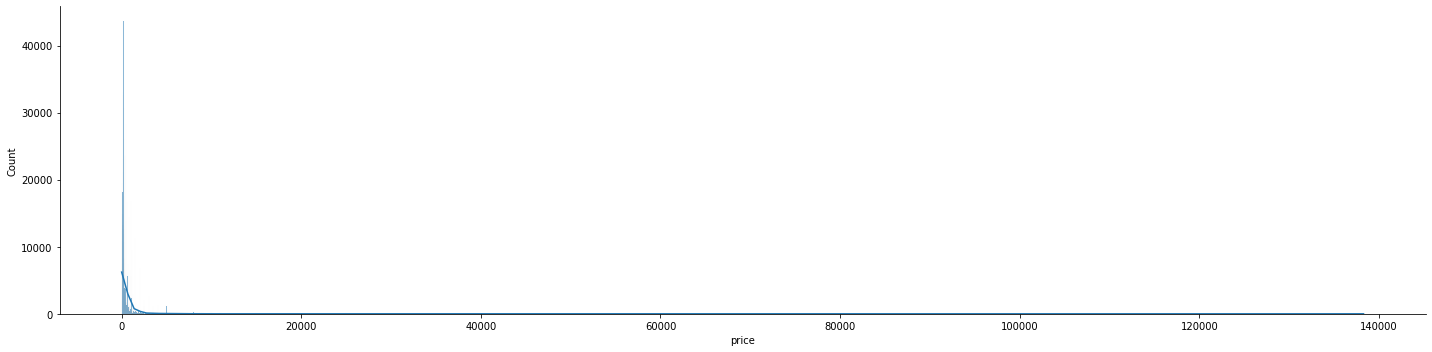

In [ ]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos contruindo um modelo para apartamentos comuns, acredito que os valores acima do limite superior serão apenas imóves de altíssimo luxo, que não é nosso objetivo principal. Por isso, podemos exlcluir esses outliers.

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,34.0,60,365,38,f,f,strict_14_with_grace_period,2018,4
1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,2.0,...,2,51.0,4,90,205,t,f,strict,2018,4
2,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,1.0,1.0,...,2,215.0,3,90,85,f,f,strict,2018,4
3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,2,45.0,4,30,208,f,f,strict,2018,4
4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,2,68.0,2,1125,200,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,2,50.0,1,1125,0,f,f,flexible,2019,9
34325,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,2.0,3.0,...,1,0.0,2,1125,0,f,f,flexible,2019,9
34326,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,1.0,2.0,...,3,30.0,3,1125,0,f,f,strict_14_with_grace_period,2019,9
34327,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,1.0,1.0,...,1,0.0,1,1125,0,f,f,strict_14_with_grace_period,2019,9


87288


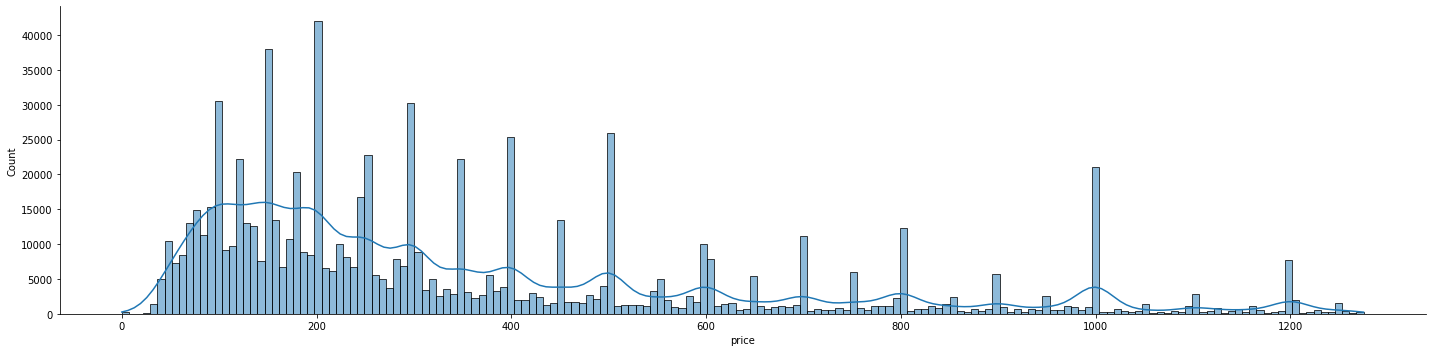

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
display(base_airbnb)
print(linhas_removidas)
histograma(base_airbnb['price'])

### extra_people

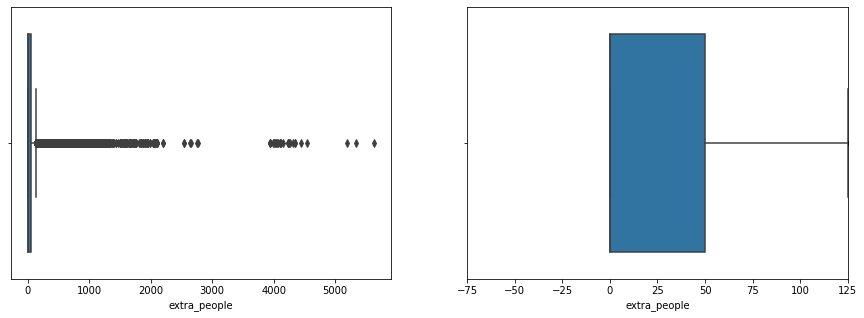

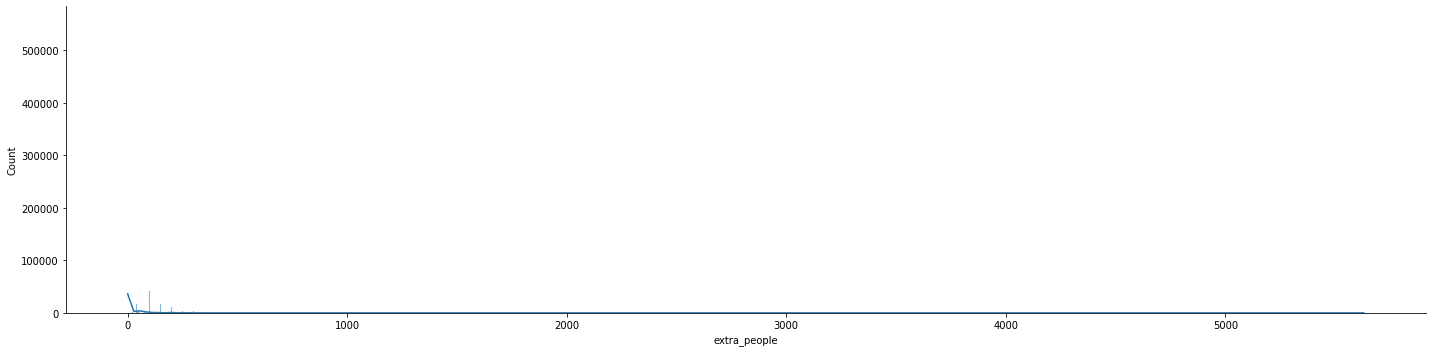

In [ ]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(linhas_removidas)

59866


### host_listings_count

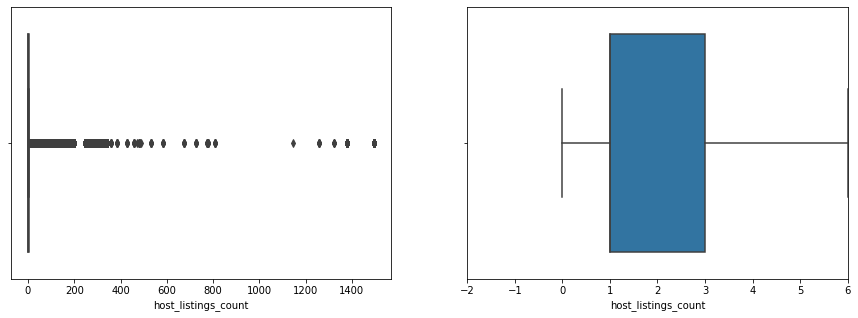

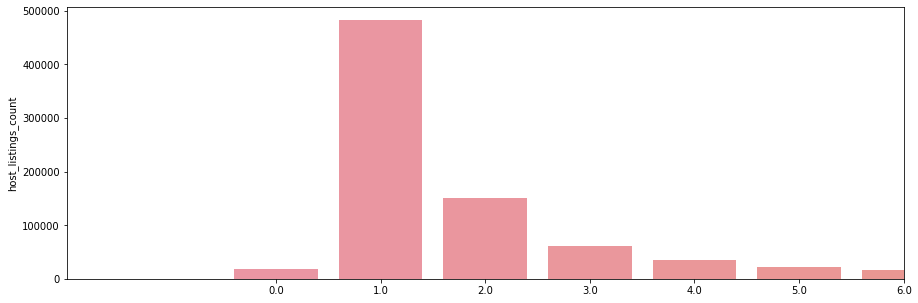

In [ ]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [ ]:
Podemos excluir os outliers, por que hosts com mais de 6 imóveis (provavelmente trabalham com isso) não são nosso
público alvo

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(linhas_removidas)

129919


### accommodates

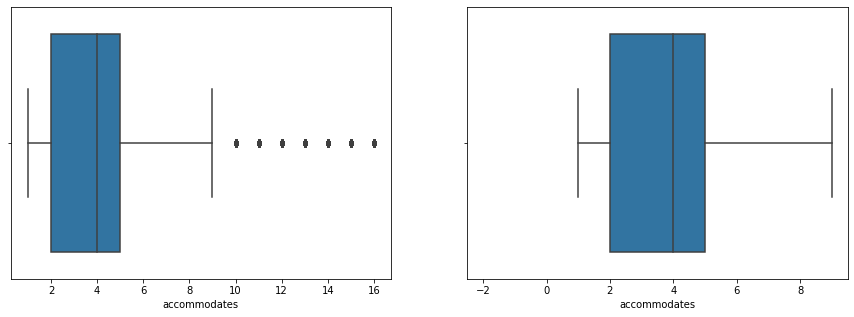

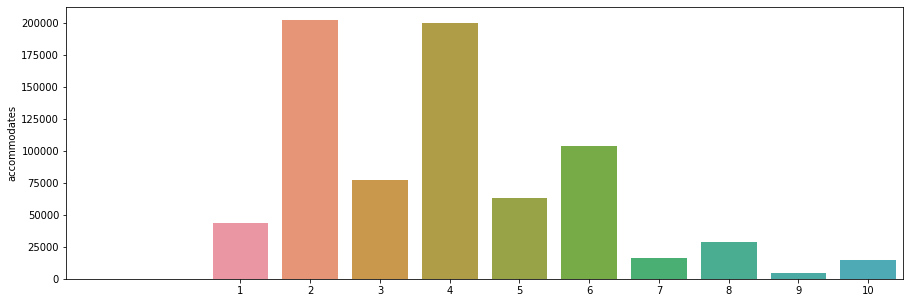

In [ ]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(linhas_removidas)

27884


### bathrooms

<AxesSubplot:ylabel='bathrooms'>

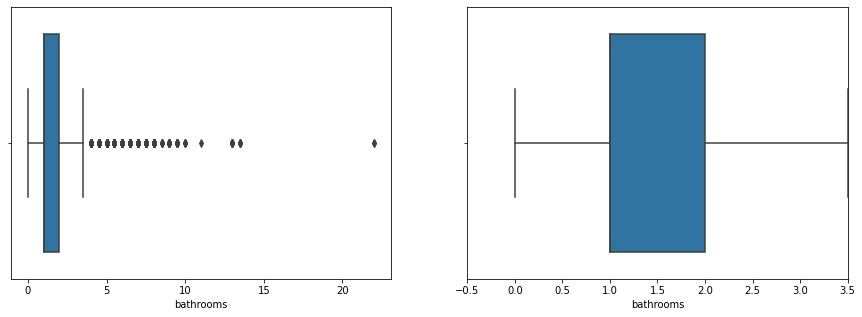

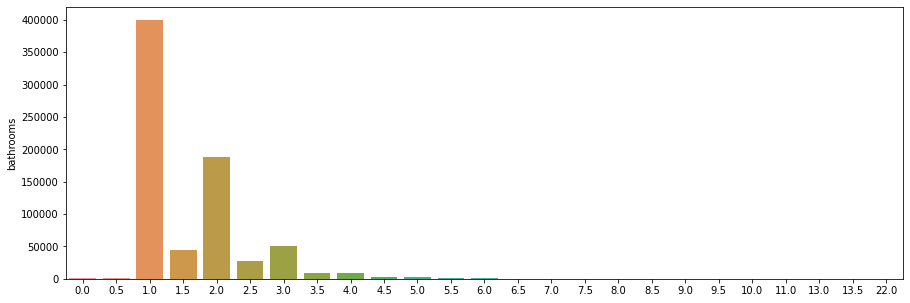

In [ ]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} Linhas removidas')

26363 Linhas removidas


In [ ]:
print(f' Até agora sobraram {base_airbnb.shape[0]} linhas')

 Até agora sobraram 713543 linhas


### beds

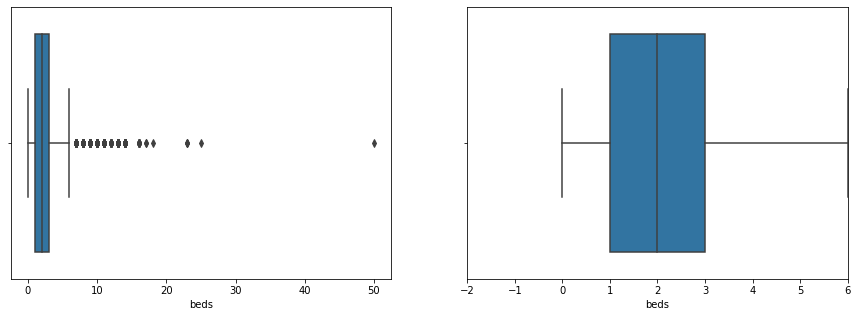

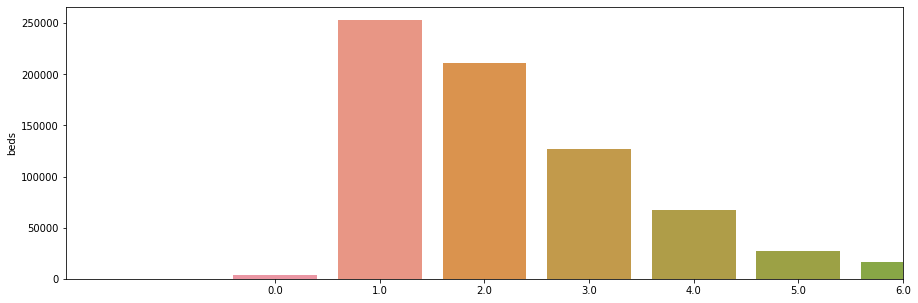

In [ ]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas} Linhas removidas')

24638 Linhas removidas


### bedrooms

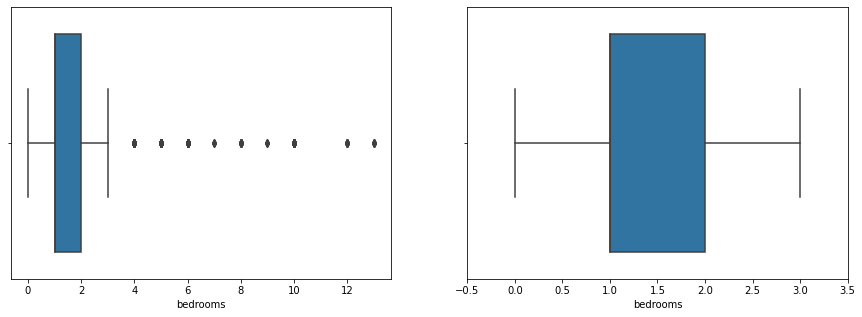

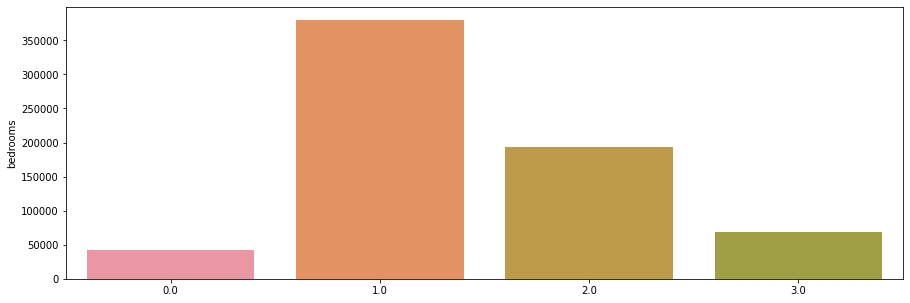

In [ ]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas} Linhas removidas da coluna bedrooms')

5306 Linhas removidas


### guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

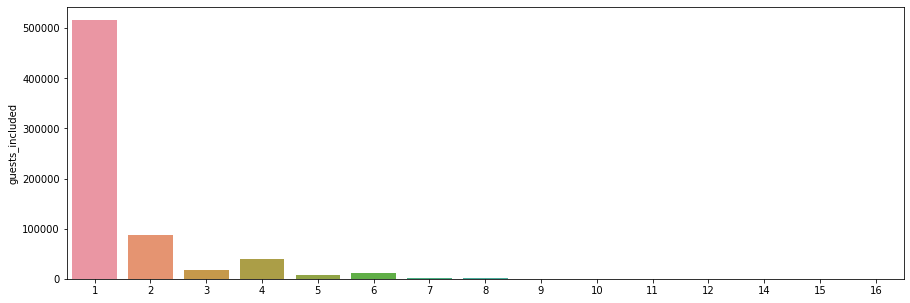

In [ ]:
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos excluir essa feature da análise. Parece que os usuários do Airbnb usam muito o valor padrão como 1 guest included, isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para definição do preço. Por isso me parece melhor excluir a coluna da análise.

In [ ]:
base_airbnb.drop('guests_included', axis=1, inplace=True)
print(base_airbnb.shape)

(683599, 22)


### minimum_nights

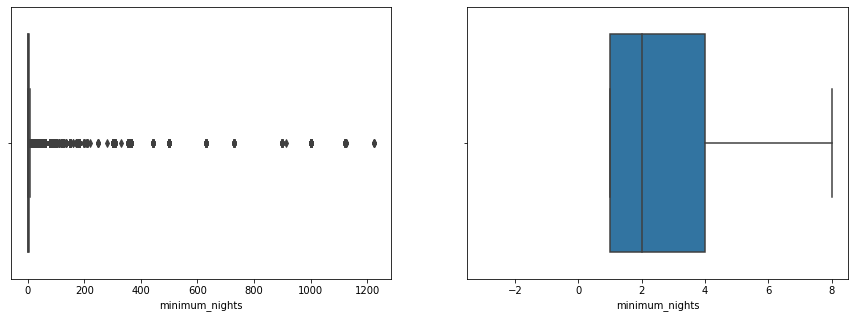

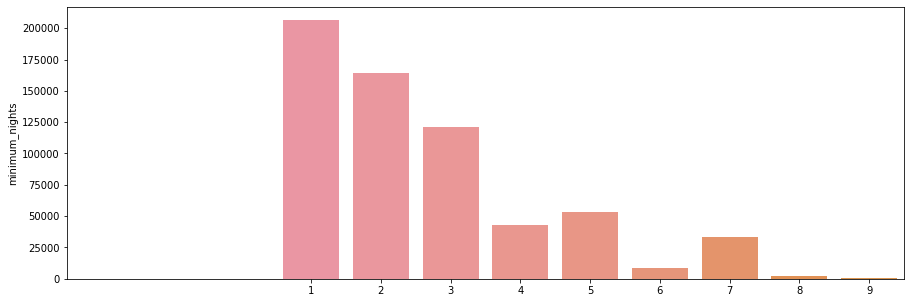

In [ ]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas} Linhas removidas da coluna minimum_nights')

50896 Linhas removidas da coluna minimum_nights


### maximum_nights

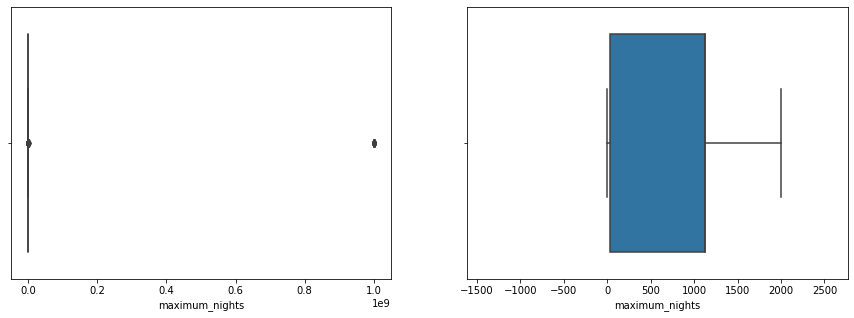

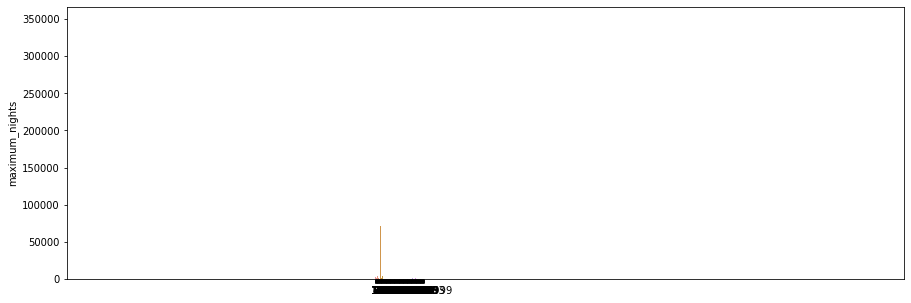

In [ ]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [ ]:
base_airbnb.drop('maximum_nights', axis=1, inplace=True)
print(base_airbnb.shape[1])

21


### number_of_reviews             

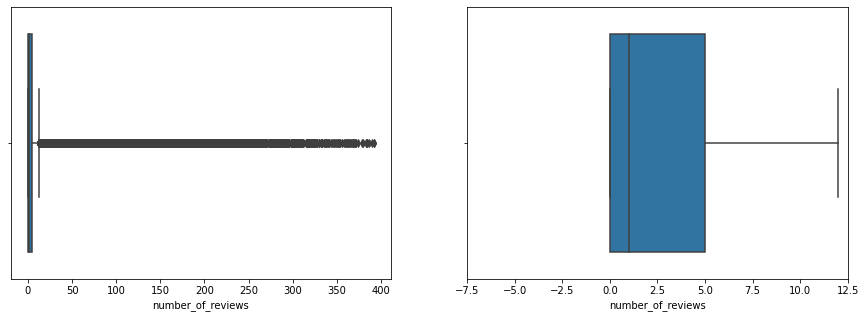

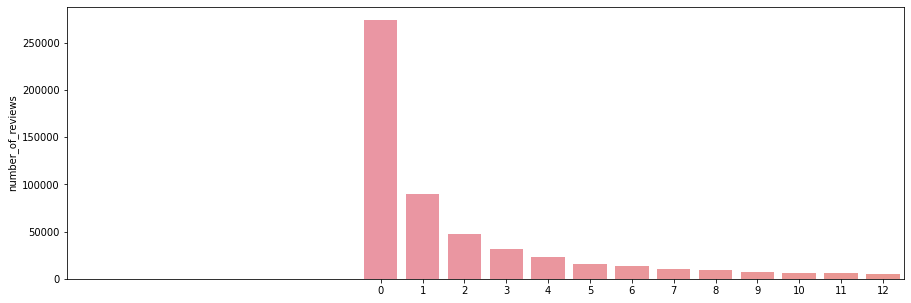

In [ ]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [ ]:
base_airbnb.drop('number_of_reviews', axis=1, inplace=True)
print(base_airbnb.shape[1])

20


In [ ]:
print(f'Linhas restantes: {base_airbnb.shape[0]}')

Linhas restantes: 632703


## Tratamento das colunas de texto

### property_type

Apartment                 504945
House                      53573
Condominium                28087
Loft                       13053
Serviced apartment         12830
Guest suite                 3675
Bed and breakfast           2955
Hostel                      2451
Guesthouse                  2132
Other                       1955
Villa                       1367
Townhouse                    896
Aparthotel                   684
Chalet                       510
Hotel                        506
Tiny house                   467
Earth house                  436
Boutique hotel               335
Casa particular (Cuba)       300
Boat                         270
Cottage                      224
Bungalow                     210
Dorm                         184
Cabin                         91
Nature lodge                  83
Castle                        80
Treehouse                     76
Island                        54
Resort                        42
Hut                           40
Campsite  

c:\users\vnsou\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


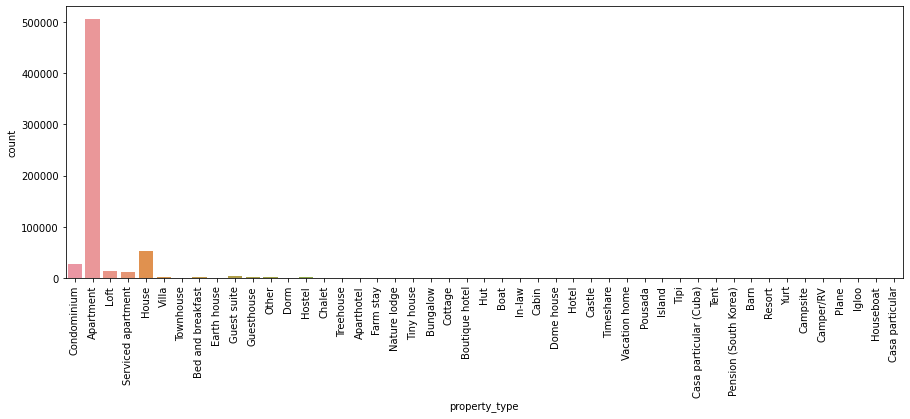

In [ ]:
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Apartment             504945
House                  53573
Condominium            28087
Loft                   13053
Serviced apartment     12830
Outros                  9002
Guest suite             3675
Bed and breakfast       2955
Hostel                  2451
Guesthouse              2132
Name: property_type, dtype: int64


c:\users\vnsou\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


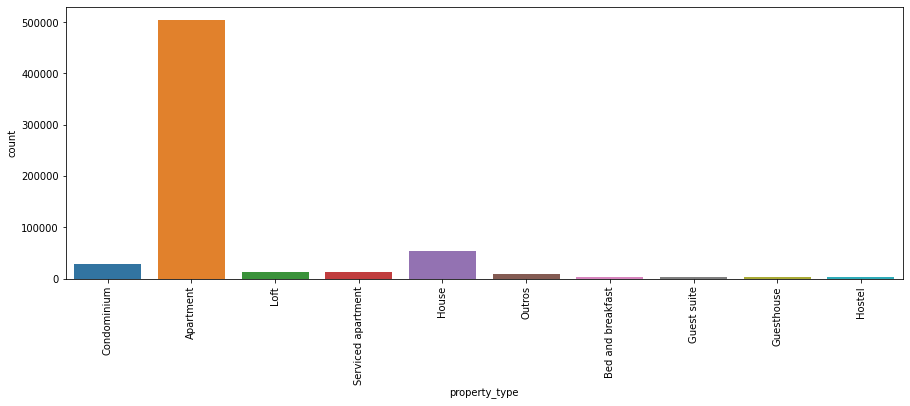

In [ ]:
"""print(base_airbnb['property_type'].value_counts().loc[lambda x: x < 2000])
others = base_airbnb['property_type'].value_counts().loc[lambda x: x < 2000]
others = others.to_frame()
outros = []
for tipo in others.index:
    outros.append(tipo)
print(outros)
"""
tipos_de_casa = base_airbnb['property_type'].value_counts()

outros = []
for tipo in tipos_de_casa.index:
    if tipos_de_casa[tipo] < 2000:
        outros.append(tipo)
#print(outros)
#print(base_airbnb['property_type'].value_counts())

for tipo in tipos_de_casa.index:
    if tipo in outros:
        print(tipo, tipos_de_casa[tipo])

for tipo in outros:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### room_type

Entire home/apt    415332
Private room       204947
Shared room         11663
Hotel room            761
Name: room_type, dtype: int64


c:\users\vnsou\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


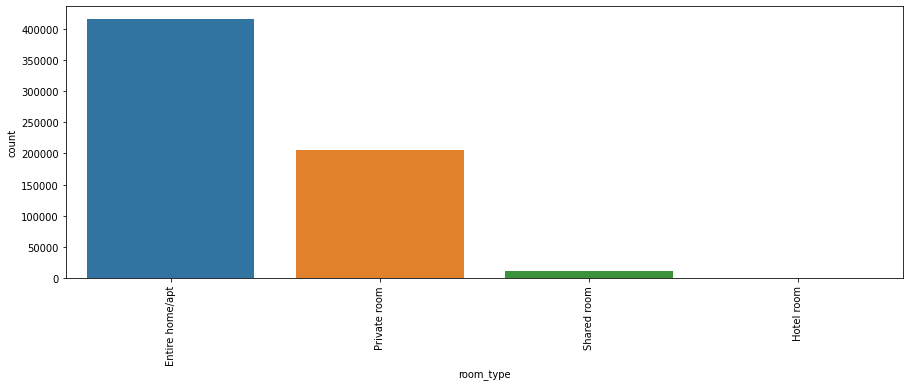

In [ ]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### bed_type

Real Bed         620535
Pull-out Sofa      8548
Futon              1824
Airbed             1257
Couch               539
Name: bed_type, dtype: int64


c:\users\vnsou\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


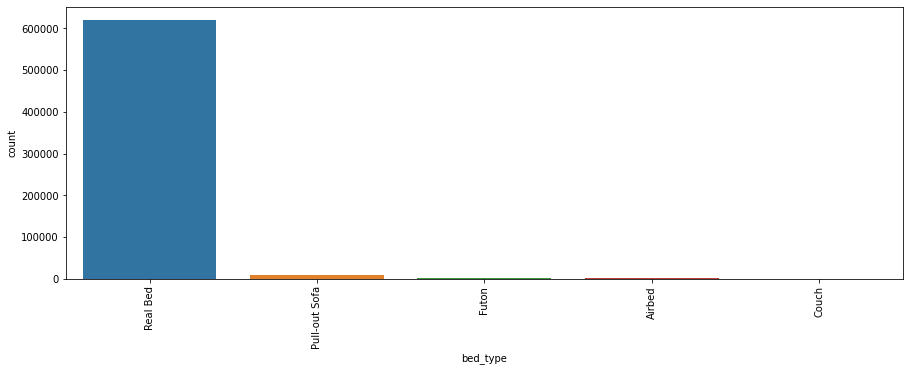

In [ ]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Criando uma lista com os tipos com menos ocorrências

In [ ]:
tipos_de_cama = base_airbnb['bed_type'].value_counts()
outros_tipos = []
for tipo in tipos_de_cama.index:
    if tipos_de_cama[tipo] < 10000:
        outros_tipos.append(tipo)
print(outros_tipos)

[]
Real Bed        620535
Outros tipos     12168
Name: bed_type, dtype: int64


Agrupando os outros tipos com menos valores

In [ ]:
for tipo in outros_tipos:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros tipos'
print(base_airbnb['bed_type'].value_counts())

Real Bed        620535
Outros tipos     12168
Name: bed_type, dtype: int64


c:\users\vnsou\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


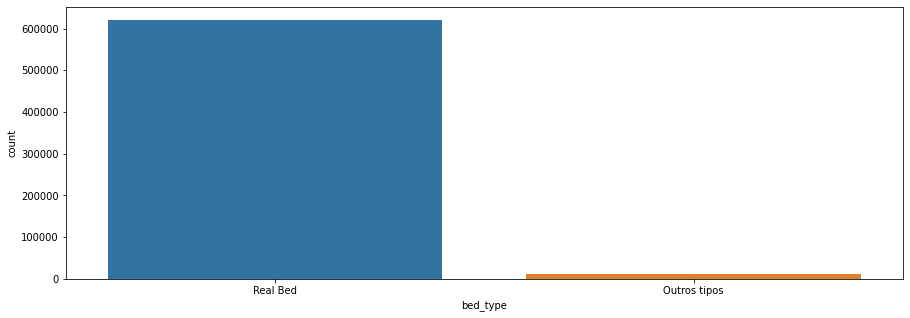

In [ ]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)

### cancellation_policy

flexible                       284526
strict_14_with_grace_period    217521
moderate                       120164
strict                          10358
super_strict_60                   107
super_strict_30                    27
Name: cancellation_policy, dtype: int64


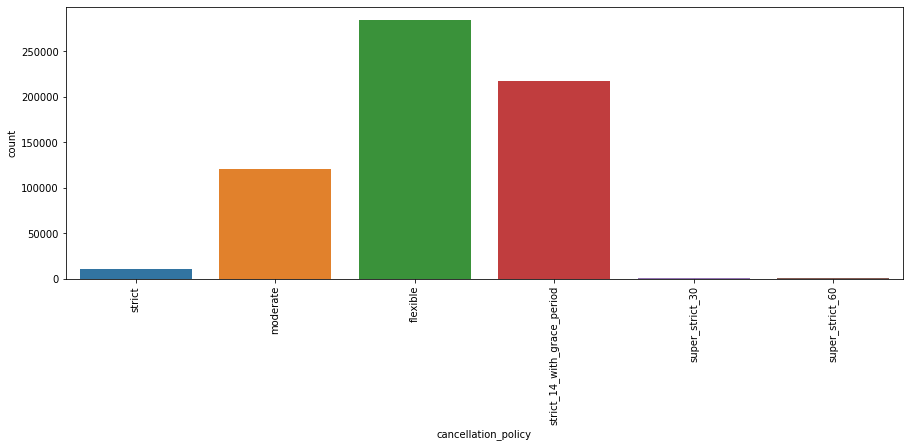

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### agrupando linhas 'strict'

# --------------------------------------------------erro----------------------------------------------------

Abaixo eu digitei o código errado e exclui todos os valores da coluna 'cancellation_policy' deixando apenas o index 'strict', vou setar a mão os valores abaixo novamente:
flexible                       284526
strict_14_with_grace_period    217521
moderate                       120164
strict                          10358
super_strict_60                   107
super_strict_30                    27

In [ ]:
#new_series = pd.Series(['flexible', 'strict_14_with_grace_period', 'moderate'])
#base_airbnb['cancellation_policy'].value_counts()
#base_airbnb.append(new_series, ignore_index=True)
# print(base_airbnb.value_counts())

new_cancellation_policy = pd.Series(name='new_cancellation_policy', index=['flexible', 'strict_14_with_grace_period', 'moderate', 'strict'],
         data=[284526, 217521, 120164, 10495])

print(new_cancellation_policy)


flexible                       284526
strict_14_with_grace_period    217521
moderate                       120164
strict                          10495
Name: new_cancellation_policy, dtype: int64


In [ ]:
print(base_airbnb['cancellation_policy'])
# base_airbnb['cancellation_policy'] = new_cancellation_policy
print(base_airbnb['cancellation_policy'].value_counts())

1        strict
2        strict
3        strict
4        strict
5        strict
          ...  
34323    strict
34324    strict
34325    strict
34327    strict
34328    strict
Name: cancellation_policy, Length: 632703, dtype: object
strict    632703
Name: cancellation_policy, dtype: int64


In [ ]:
# print(base_airbnb['cancellation_policy'].value_counts())

cancelamento = base_airbnb['cancellation_policy'].value_counts()
print(cancelamento)
strict = []
for tipo in cancelamento.index:
    if cancelamento[tipo] < 50000:
        strict.append(tipo)
print(strict)

#for tipo in cancelamento.index:
 #   base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'
#print(base_airbnb['cancellation_policy'].value_counts())

strict    632703
Name: cancellation_policy, dtype: int64
[]


### Nada acima funcionou e agora estou sem os dados da coluna cancellation_policy, vou ter que carregar novamente os dados originais que não foram modificados, preciso descobrir como fazer isso

### Tentando resgatar a coluna cancellatin_policy original sem os dados excluidos

In [ ]:
caminho_bases_backup = pathlib.Path('dataset')
base_airbnb_backup = pd.DataFrame()

for arquivo in caminho_bases_backup.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:-4]
    #ou ano = arquivo.name[-8:]
    #ano = int(ano.replace('.csv', ''))

    df_backup = pd.read_csv(caminho_bases_backup / arquivo.name)
    df_backup['ano'] = ano
    df_backup['mes'] = mes
    base_airbnb_backup = base_airbnb_backup.append(df_backup)

display(base_airbnb_backup.head())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(base_airbnb_backup['cancellation_policy'].value_counts())
base_airbnb.drop('cancellation_policy', axis=1)
base_airbnb['cancellation_policy'] = base_airbnb_backup['cancellation_policy']
print(base_airbnb['new_cancellation_policy'].value_counts())

flexible                       386758
strict_14_with_grace_period    338301
moderate                       149753
strict                          16243
super_strict_60                  8202
super_strict_30                  2953
Name: cancellation_policy, dtype: int64


ValueError: cannot reindex from a duplicate axis

# --------------------------------------------------erro----------------------------------------------------
Nada acima funcionou, tempo tentando: aprox. 2h

In [ ]:
display(base_airbnb.head())
display(base_airbnb_backup.head())

### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo